## Imports

In [5]:
import random, os
import time
import json
import hashlib
from datetime import datetime, timedelta
import pandas as pd
import hashlib
import flwr as fl
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

## Step0: Simulator

In [6]:
# ---------------------- Configuration ----------------------
PROTOCOLS = [
    "MQTT:PUBLISH", "MQTT:SUBSCRIBE", "MQTT:UNSUBSCRIBE",
    "libp2p:GRAFT", "libp2p:PRUNE", "libp2p:IHAVE", "libp2p:IWANT",
    "devp2p:GetBlockHeaders", "devp2p:Transactions", "devp2p:NewBlock",
    "discovery:Ping", "discovery:Pong", "discovery:FindNode", "discovery:Neighbors",
    "ENR:Request", "ENR:Response"
]

# ---------------------- Node Class ----------------------
class Node:
    def __init__(self, node_id, is_sybil=False):
        self.node_id = node_id
        self.is_sybil = is_sybil
        self.behavior_type = random.choice(["spammer", "evasive", "flooder"]) if is_sybil else "normal"

    def generate_metrics(self):
        if self.is_sybil:
            latency = random.uniform(5, 50)
            energy = random.uniform(30, 70)
            enr_similarity = random.uniform(0.9, 1.0)
        else:
            latency = random.uniform(100, 300)
            energy = random.uniform(60, 100)
            enr_similarity = random.uniform(0.0, 0.3)
        return latency, energy, enr_similarity

    def send_message(self, network, forced_target=None):
        target = forced_target or network.random_node(exclude=self.node_id)
        if not target:
            return

        if self.is_sybil:
            if self.behavior_type == "spammer":
                protocol = random.choice(["MQTT:PUBLISH"] * 3)
            elif self.behavior_type == "evasive":
                protocol = random.choice(["ENR:Request", "libp2p:PRUNE"])
            else:  # flooder
                protocol = random.choice(["discovery:Ping", "discovery:FindNode"])
        else:
            protocol = random.choice(PROTOCOLS)

        latency, energy, enr_similarity = self.generate_metrics()
        timestamp = datetime.now().isoformat()
        msg = {
            "timestamp": timestamp,
            "from": self.node_id,
            "to": target.node_id,
            "protocol": protocol,
            "latency_ms": latency,
            "message_size_bytes": random.randint(128, 2048),
            "energy_remaining": energy,
            "enr_similarity": enr_similarity,
            "is_sybil": self.is_sybil
        }
        network.logs.append(msg)

# ---------------------- Network Class ----------------------
class Network:
    def __init__(self, honest_count=10, sybil_clones=5):
        self.nodes = {}
        self.logs = []
        for i in range(honest_count):
            node_id = f"Node{i:03}"
            self.nodes[node_id] = Node(node_id, is_sybil=False)
            for j in range(sybil_clones):
                sybil_id = f"{node_id}_Sybil{j:02}"
                self.nodes[sybil_id] = Node(sybil_id, is_sybil=True)

    def random_node(self, exclude=None):
        candidates = [n for n in self.nodes.values() if n.node_id != exclude]
        return random.choice(candidates) if candidates else None

    def simulate_round(self, messages_per_node=10):
        for node in self.nodes.values():
            for _ in range(messages_per_node):
                node.send_message(self)

    def export_to_dataframe(self):
        return pd.DataFrame(self.logs)

# ---------------------- Run Simulation ----------------------
network = Network(honest_count=10, sybil_clones=5)
for _ in range(5):
    network.simulate_round(messages_per_node=10)
    time.sleep(0.05)

df_simulated = network.export_to_dataframe()

df_simulated.to_csv("ver2.csv", index=False)
print("Dataset saved to sybil_simulated_dataset.csv")


Dataset saved to sybil_simulated_dataset.csv


## Feature extraction and Augmentation

In [7]:
# Load the simulated dataset
df = pd.read_csv("sybil_simulated_dataset.csv")

# Step 1: Aggregate Features Per Node
agg_features = df.groupby("from").agg({
    "latency_ms": ["mean", "std"],
    "message_size_bytes": "mean",
    "energy_remaining": "mean",
    "enr_similarity": "mean",
    "protocol": pd.Series.nunique,
    "is_sybil": "max"
}).reset_index()

agg_features.columns = ["node_id", "latency_mean", "latency_std", "msg_size_mean", "energy_mean", 
                        "enr_similarity_mean", "unique_protocols", "is_sybil"]

# Step 2: Generate DFL Score (simulated using heuristic anomaly score)
agg_features["dfl_score"] = (
    (1 - agg_features["enr_similarity_mean"]) * 40 +
    agg_features["energy_mean"] * 0.4 +
    agg_features["unique_protocols"] * 5 -
    agg_features["latency_std"] * 0.1
).clip(lower=0, upper=100).round(2)

# Step 3: Generate behavior hash per node
def make_behavior_hash(row):
    concat = f"{row['latency_mean']:.2f}|{row['msg_size_mean']:.2f}|{row['energy_mean']:.2f}|{row['enr_similarity_mean']:.2f}"
    return hashlib.sha256(concat.encode()).hexdigest()

agg_features["behavior_hash"] = agg_features.apply(make_behavior_hash, axis=1)

# Select final smart contract inputs
contract_inputs = agg_features[["node_id", "dfl_score", "behavior_hash", "is_sybil"]]

# Save the smart contract input to CSV locally
contract_inputs.to_csv("contract_inputs.csv", index=False)
print("Smart contract input saved to contract_inputs.csv")


Smart contract input saved to contract_inputs.csv


In [ ]:
#!pip install flwr scikit-learn pandas

## Step 3: Running Decentralized Federated Learning (DFL)

## #1: Split per node

In [11]:
df = pd.read_csv("sybil_simulated_dataset.csv")
os.makedirs("nodes_data", exist_ok=True)

for node_id, group in df.groupby("from"):
    group.to_csv(f"nodes_data/{node_id}.csv", index=False)
print("Split complete.")


Split complete.


## #2: Federated server: run server.py first then client.py in vscode: it is running paralell clients

In [ ]:
# from flwr.server import ServerConfig
# import flwr as fl

# config = ServerConfig(num_rounds=3)
# fl.server.start_server(server_address="127.0.0.1:8080", config=config)


## Analyzing the dataset as we got low accuracy

In [ ]:
!pip install seaborn

🔍 Class distribution:
is_sybil
1    2500
0     500
Name: count, dtype: int64


C:\Users\erfan\AppData\Local\Temp\ipykernel_17840\1482599085.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="is_sybil", palette="Set2")


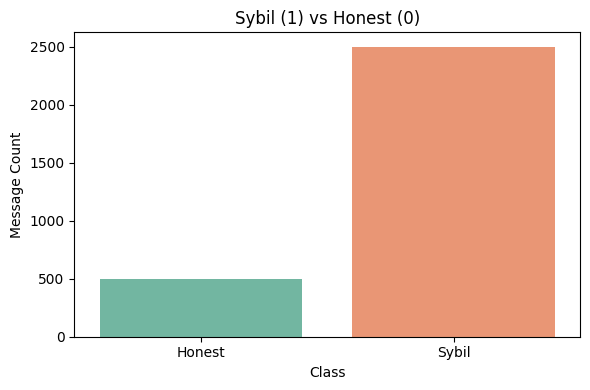

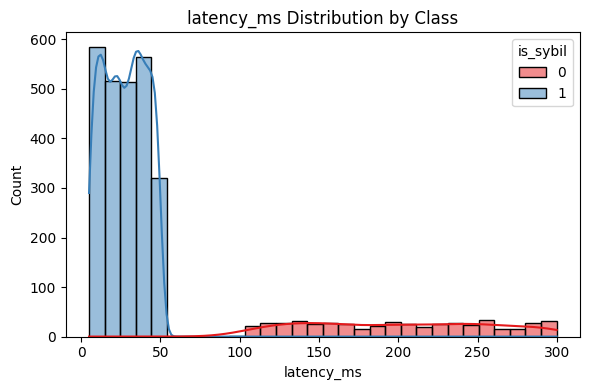

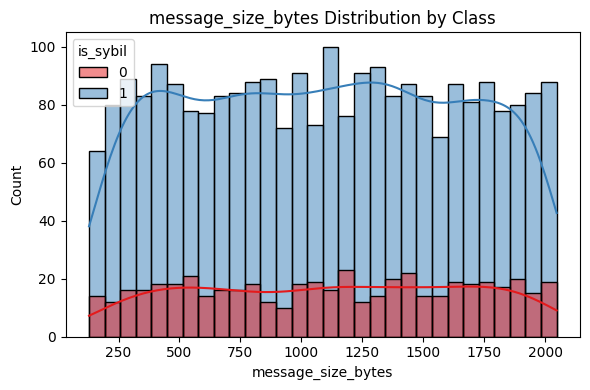

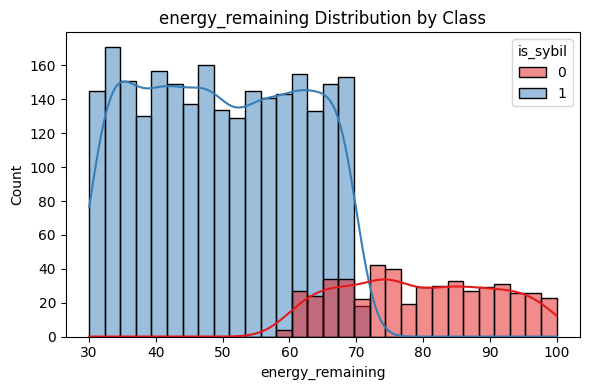

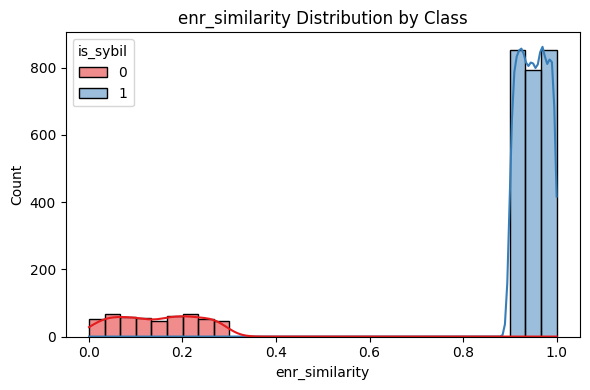

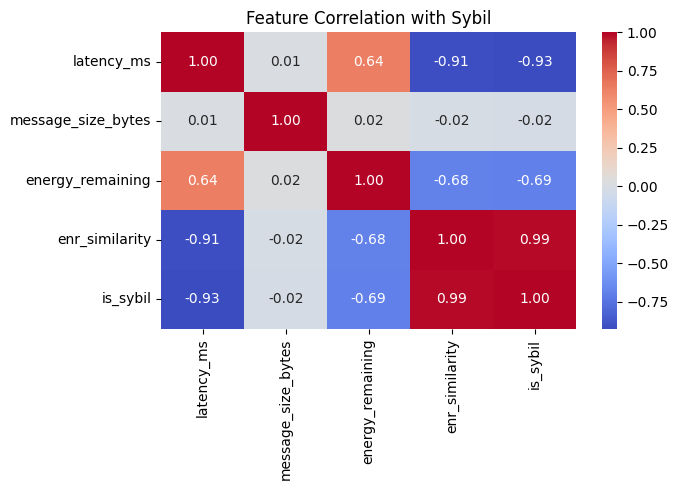

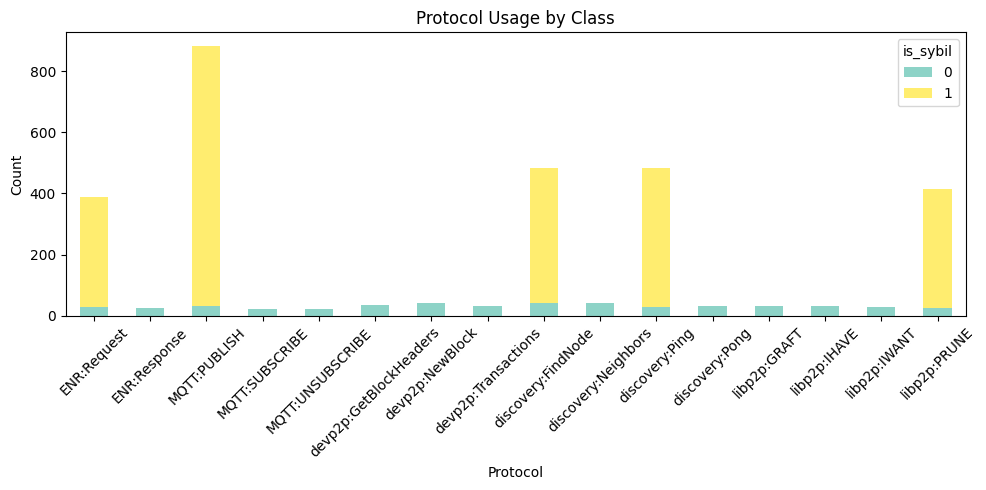

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("sybil_simulated_dataset.csv")

# Convert 'is_sybil' to integer for analysis
df["is_sybil"] = df["is_sybil"].astype(int)

# -----------------------------
# 1. Class Distribution
# -----------------------------
print("🔍 Class distribution:")
print(df["is_sybil"].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="is_sybil", palette="Set2")
plt.title("Sybil (1) vs Honest (0)")
plt.xlabel("Class")
plt.ylabel("Message Count")
plt.xticks([0, 1], ["Honest", "Sybil"])
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Feature Distributions
# -----------------------------
features = ["latency_ms", "message_size_bytes", "energy_remaining", "enr_similarity"]

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=feature, hue="is_sybil", kde=True, bins=30, palette="Set1")
    plt.title(f"{feature} Distribution by Class")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 3. Correlation Matrix
# -----------------------------
corr = df[features + ["is_sybil"]].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation with Sybil")
plt.tight_layout()
plt.show()

# -----------------------------
# 4. Protocol Usage Comparison
# -----------------------------
protocol_counts = df.groupby("is_sybil")["protocol"].value_counts().unstack().fillna(0)

protocol_counts.T.plot(kind="bar", figsize=(10, 5), stacked=True, colormap="Set3")
plt.title("Protocol Usage by Class")
plt.ylabel("Count")
plt.xlabel("Protocol")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## comprehensive simulator :(((((((((((

In [12]:
import os
import time
import json
import random
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from scipy.stats import entropy

# --- Configuration ---
PROTOCOLS = [
    "MQTT:PUBLISH", "MQTT:SUBSCRIBE", "MQTT:UNSUBSCRIBE",
    "libp2p:GRAFT", "libp2p:PRUNE", "libp2p:IHAVE", "libp2p:IWANT",
    "devp2p:GetBlockHeaders", "devp2p:Transactions", "devp2p:NewBlock",
    "discovery:Ping", "discovery:Pong", "discovery:FindNode", "discovery:Neighbors",
    "ENR:Request", "ENR:Response"
]
LOG_FILE = "balanced_logs.jsonl"
FINAL_CSV = "balanced_sybil_dataset.csv"
WINDOW_SIZE = 5

# --- Node Class ---
class Node:
    def __init__(self, node_id, is_sybil=False):
        self.node_id = node_id
        self.is_sybil = is_sybil
        self.behavior_type = random.choice(["spammer", "evasive", "flooder"]) if is_sybil else "normal"

    def generate_metrics(self):
        if self.is_sybil:
            latency = random.uniform(5, 50)
            energy = random.uniform(30, 70)
            enr_similarity = random.uniform(0.9, 1.0)
        else:
            latency = random.uniform(100, 300)
            energy = random.uniform(60, 100)
            enr_similarity = random.uniform(0.0, 0.3)
        return latency, energy, enr_similarity

    def send_message(self, network, forced_target=None):
        target = forced_target or network.random_node(exclude=self.node_id)
        if not target:
            return

        if self.is_sybil:
            if self.behavior_type == "spammer":
                protocol = random.choice(["MQTT:PUBLISH"] * 3)
            elif self.behavior_type == "evasive":
                protocol = random.choice(["ENR:Request", "libp2p:PRUNE"])
            else:
                protocol = random.choice(["discovery:Ping", "discovery:FindNode"])
        else:
            protocol = random.choice(PROTOCOLS)

        latency, energy, enr_similarity = self.generate_metrics()
        msg = {
            "timestamp": time.time(),
            "from": self.node_id,
            "to": target.node_id,
            "protocol": protocol,
            "latency_ms": latency,
            "message_size_bytes": random.randint(128, 2048),
            "energy_remaining": energy,
            "enr_similarity": enr_similarity,
            "is_sybil": self.is_sybil
        }
        network.logs.append(msg)

# --- Network Class ---
class Network:
    def __init__(self, honest_count=150, sybil_clones=2):
        self.nodes = {}
        self.logs = []
        self.sybil_ids = set()

        for i in range(honest_count):
            node_id = f"Node{i:03}"
            self.nodes[node_id] = Node(node_id, is_sybil=False)
            for j in range(sybil_clones):
                sybil_id = f"{node_id}_Sybil{j:02}"
                self.nodes[sybil_id] = Node(sybil_id, is_sybil=True)
                self.sybil_ids.add(sybil_id)

    def random_node(self, exclude=None):
        return random.choice([n for n in self.nodes.values() if n.node_id != exclude])

    def simulate_round(self, messages_per_node=10):
        for node in self.nodes.values():
            for _ in range(messages_per_node):
                node.send_message(self)

    def export_logs(self):
        with open(LOG_FILE, "w") as f:
            for m in self.logs:
                f.write(json.dumps(m) + "\n")

# --- Run Simulation ---
if __name__ == "__main__":
    print("[+] Starting balanced simulation...")
    net = Network(honest_count=50, sybil_clones=2)
    for _ in range(15):
        net.simulate_round(messages_per_node=10)
        time.sleep(0.05)
    net.export_logs()
    print(f"[✓] Logs exported to {LOG_FILE}")

    # --- Feature Extraction ---
    print("[+] Extracting features...")
    with open(LOG_FILE, "r") as f:
        logs = [json.loads(line) for line in f]
    logs.sort(key=lambda x: x["timestamp"])

    node_messages = defaultdict(list)
    for log in logs:
        node_messages[log["from"]].append(("sent", log))
        node_messages[log["to"]].append(("received", log))

    rows = []
    for node_id, messages in node_messages.items():
        messages.sort(key=lambda x: x[1]["timestamp"])
        for i in range(0, len(messages) - WINDOW_SIZE + 1, WINDOW_SIZE):
            window = messages[i:i + WINDOW_SIZE]
            sent_total = received_total = 0
            protocols = []
            peers = set()
            timestamps = []

            for direction, msg in window:
                proto = msg["protocol"]
                peer = msg["to"] if direction == "sent" else msg["from"]
                timestamps.append(msg["timestamp"])
                protocols.append(proto)
                peers.add(peer)
                if direction == "sent":
                    sent_total += 1
                else:
                    received_total += 1

            proto_counts = Counter(protocols)
            dominant_ratio = max(proto_counts.values()) / len(protocols) if protocols else 0.0
            mqtt_ratio = sum(1 for p in protocols if p.startswith("MQTT")) / len(protocols) if protocols else 0.0
            discovery_ratio = sum(1 for p in protocols if p.startswith("discovery")) / len(protocols) if protocols else 0.0
            proto_entropy = entropy(list(proto_counts.values()), base=2) if len(proto_counts) > 1 else 0.0

            burstiness = 0.0
            if len(timestamps) > 1:
                gaps = np.diff(sorted(timestamps))
                if len(gaps) > 1:
                    burstiness = np.std(gaps)

            row = {
                "node_id": node_id,
                "sent_total": sent_total,
                "received_total": received_total,
                "protocol_diversity": len(set(protocols)),
                "message_burstiness": round(burstiness, 5),
                "dominant_protocol_ratio": round(dominant_ratio, 4),
                "mqtt_ratio": round(mqtt_ratio, 4),
                "discovery_ratio": round(discovery_ratio, 4),
                "protocol_entropy": round(proto_entropy, 4),
                "unique_peers": len(peers),
                "is_sybil": node_id in net.sybil_ids
            }
            rows.append(row)

    df = pd.DataFrame(rows)
    df.to_csv(FINAL_CSV, index=False)
    print(f"[✓] Final balanced dataset saved to {FINAL_CSV}")


[+] Starting balanced simulation...
[✓] Logs exported to balanced_logs.jsonl
[+] Extracting features...
[✓] Final balanced dataset saved to balanced_sybil_dataset.csv


## evaluation of dataset

🔍 Class distribution:
is_sybil
1    5957
0    2982
Name: count, dtype: int64


C:\Users\erfan\AppData\Local\Temp\ipykernel_17840\2379800990.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="is_sybil", palette="Set2")


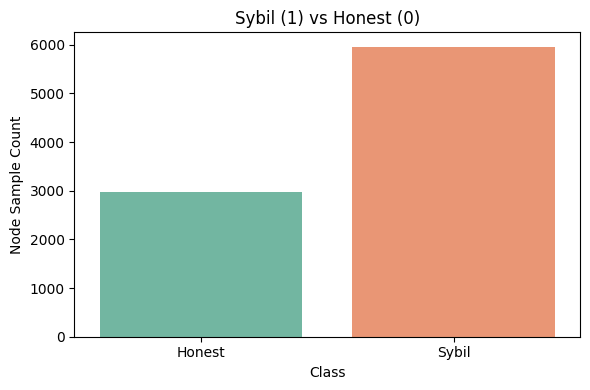

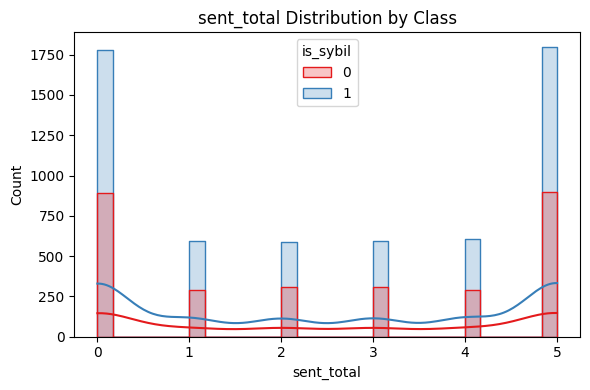

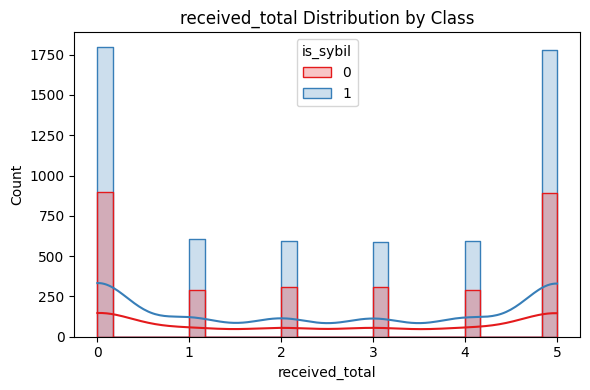

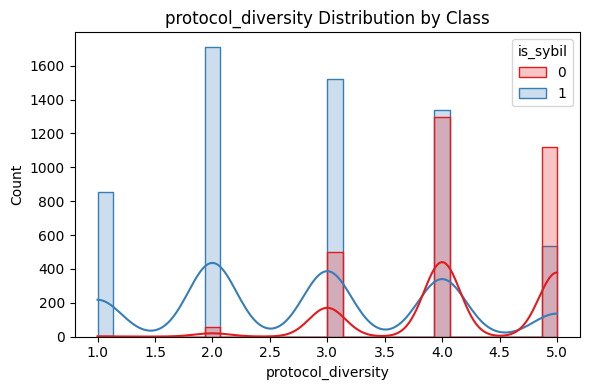

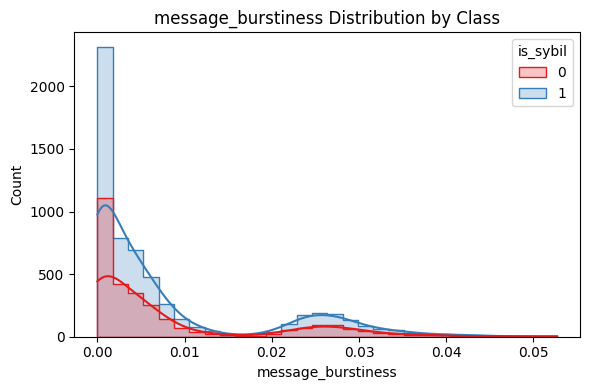

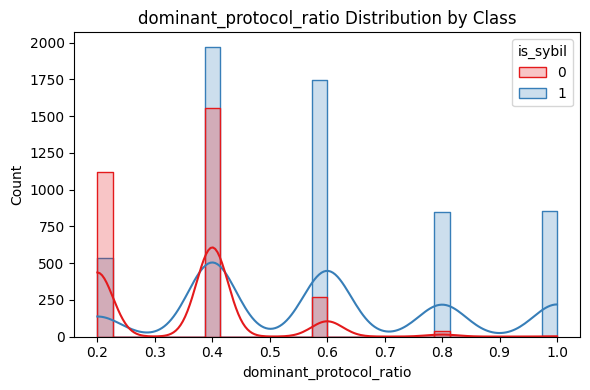

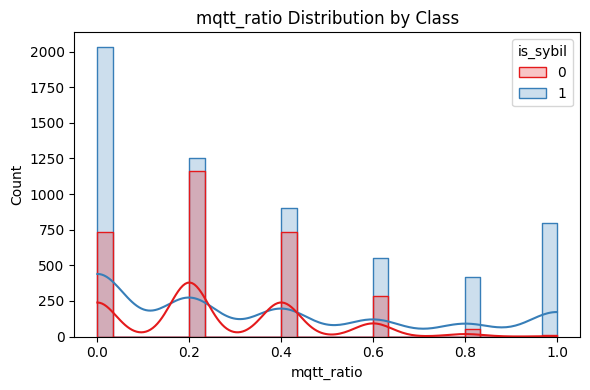

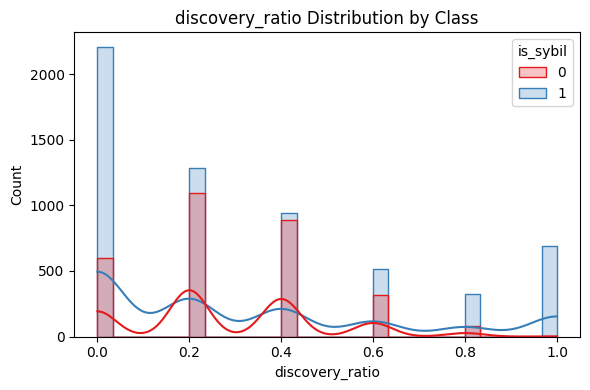

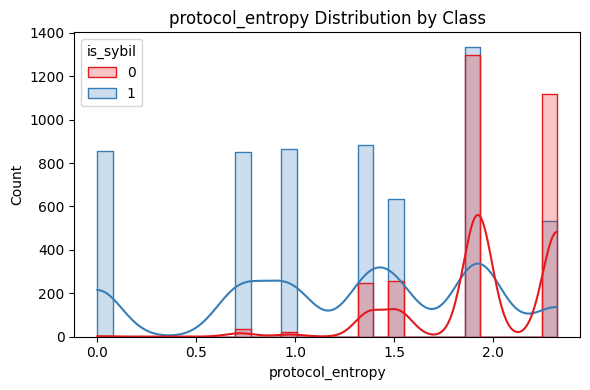

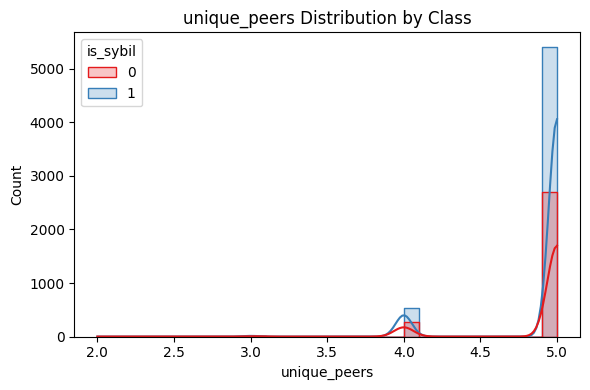

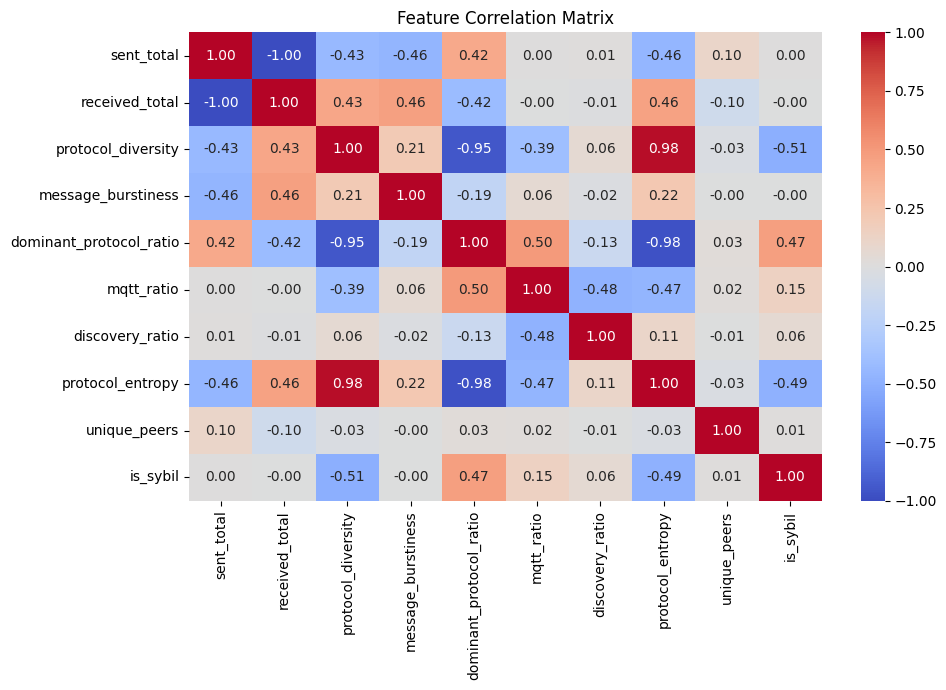

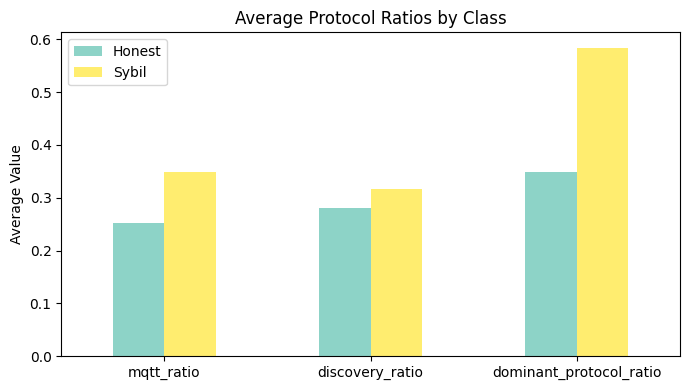

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed dataset
df = pd.read_csv("balanced_sybil_dataset.csv")  # or "final_sybil_dataset.csv"

# Ensure 'is_sybil' is in integer form
df["is_sybil"] = df["is_sybil"].astype(int)

# -----------------------------
# 1. Class Distribution
# -----------------------------
print("🔍 Class distribution:")
print(df["is_sybil"].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="is_sybil", palette="Set2")
plt.title("Sybil (1) vs Honest (0)")
plt.xlabel("Class")
plt.ylabel("Node Sample Count")
plt.xticks([0, 1], ["Honest", "Sybil"])
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Feature Distributions
# -----------------------------
features = [
    "sent_total", "received_total", "protocol_diversity", "message_burstiness",
    "dominant_protocol_ratio", "mqtt_ratio", "discovery_ratio", 
    "protocol_entropy", "unique_peers"
]

for feature in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=feature, hue="is_sybil", kde=True, bins=30, palette="Set1", element="step")
    plt.title(f"{feature} Distribution by Class")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 3. Correlation Matrix
# -----------------------------
corr = df[features + ["is_sybil"]].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# -----------------------------
# 4. Protocol Feature Comparison
# -----------------------------
protocol_features = ["mqtt_ratio", "discovery_ratio", "dominant_protocol_ratio"]

df_grouped = df.groupby("is_sybil")[protocol_features].mean().T
df_grouped.columns = ["Honest", "Sybil"]
df_grouped.plot(kind="bar", figsize=(7, 4), colormap="Set3")
plt.title("Average Protocol Ratios by Class")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [21]:
from sklearn.utils import resample

# Load the full dataset
df = pd.read_csv("balanced_sybil_dataset.csv")
os.makedirs("nodes_data", exist_ok=True)

# Shuffle the dataset
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# Split into 10 approximately equal groups
clients = []
unique_ids = df['node_id'].unique()
group_size = len(unique_ids) // 10
for i in range(10):
    ids = unique_ids[i * group_size:(i + 1) * group_size]
    clients.append(df[df['node_id'].isin(ids)])

# Balance each client's data (equal number of Sybil and Honest samples)
for i, client_df in enumerate(clients):
    sybil_df = client_df[client_df['is_sybil'] == True]
    honest_df = client_df[client_df['is_sybil'] == False]

    min_len = min(len(sybil_df), len(honest_df))

    if min_len < 20:
        print(f"Skipping client_{i} (not enough samples to balance)")
        continue

    balanced_df = pd.concat([
        resample(sybil_df, replace=False, n_samples=min_len, random_state=1),
        resample(honest_df, replace=False, n_samples=min_len, random_state=1)
    ])

    balanced_df = balanced_df.sample(frac=1.0).reset_index(drop=True)
    balanced_df.to_csv(f"nodes_data/client_{i}.csv", index=False)
    print(f"[✓] Saved balanced client_{i}.csv with {len(balanced_df)} samples")

print("✅ All clients balanced and saved.")


[✓] Saved balanced client_0.csv with 834 samples
[✓] Saved balanced client_1.csv with 708 samples
[✓] Saved balanced client_2.csv with 720 samples
[✓] Saved balanced client_3.csv with 580 samples
[✓] Saved balanced client_4.csv with 708 samples
[✓] Saved balanced client_5.csv with 478 samples
[✓] Saved balanced client_6.csv with 608 samples
[✓] Saved balanced client_7.csv with 246 samples
[✓] Saved balanced client_8.csv with 712 samples
[✓] Saved balanced client_9.csv with 370 samples
✅ All clients balanced and saved.


## Split per node:

In [19]:
# df = pd.read_csv("balanced_sybil_dataset.csv")
# os.makedirs("nodes_data", exist_ok=True)

# group_size = 15
# unique_nodes = df['node_id'].unique()
# for i, group in enumerate(range(0, len(unique_nodes), group_size)):
#     selected = unique_nodes[group:group+group_size]
#     client_df = df[df['node_id'].isin(selected)]
#     client_df.to_csv(f"nodes_data/client_{i}.csv", index=False)
# print("✅ Split into grouped clients (15 nodes/client)")

✅ Split into grouped clients (15 nodes/client)


In [20]:
# for i in range(10):
#     df = pd.read_csv(f"nodes_data/client_{i}.csv")
#     print(f"client_{i}: {df['is_sybil'].value_counts().to_dict()}")


client_0: {True: 541, False: 362}
client_1: {True: 767, False: 121}
client_2: {True: 666, False: 236}
client_3: {False: 659, True: 242}
client_4: {True: 602, False: 298}
client_5: {True: 714, False: 174}
client_6: {True: 599, False: 296}
client_7: {True: 473, False: 415}
client_8: {True: 638, False: 237}
client_9: {True: 715, False: 184}


## step0+1: simulator+ feature extractor, step2: balancing data per client, step3: check class distribution:

In [22]:
import pandas as pd

print("📊 Class distribution per client:")
for i in range(10):
    df = pd.read_csv(f"nodes_data/client_{i}.csv")
    counts = df['is_sybil'].value_counts().to_dict()
    print(f"client_{i}: {counts}")


📊 Class distribution per client:
client_0: {False: 417, True: 417}
client_1: {False: 354, True: 354}
client_2: {True: 360, False: 360}
client_3: {True: 290, False: 290}
client_4: {False: 354, True: 354}
client_5: {False: 239, True: 239}
client_6: {False: 304, True: 304}
client_7: {True: 123, False: 123}
client_8: {False: 356, True: 356}
client_9: {False: 185, True: 185}


## Evaluating the global model after running on server and client:

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from nn_models import SimpleNN, ConvNN
from nn_models import get_model


# Define the model (same architecture as in client.py)
# class SimpleNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.net = nn.Sequential(
#             # nn.Linear(9, 128), nn.ReLU(),
#             # nn.Dropout(0.3),
#             # nn.Linear(128, 64), nn.ReLU(),
#             # nn.Dropout(0.2),
#             # nn.Linear(64, 32), nn.ReLU(),
#             # nn.Linear(32, 2)
#             nn.Linear(9, 256), nn.ReLU(),
#             nn.Linear(256, 128), nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, 64), nn.ReLU(),
#             nn.Linear(64, 2)
#         )

#     def forward(self, x):
#         return self.net(x)



# def get_model():
#     model = ConvNN()
#     print(f"Model with {model.count_parameters()} parameters created!")
#     return ConvNN()
    
# Load global validation set (or combine all clients)
def load_global_data():
    all_data = []
    for i in range(10):
        df = pd.read_csv(f"nodes_data/client_{i}.csv")
        all_data.append(df)
    df = pd.concat(all_data).sample(frac=1.0).reset_index(drop=True)
    X = df[[
        "sent_total", "received_total", "protocol_diversity",
        "message_burstiness", "mqtt_ratio", "discovery_ratio",
        "protocol_entropy", "unique_peers", "dominant_protocol_ratio"]].values
    y = df["is_sybil"].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    return X_tensor, y_tensor

# Load saved global model weights from a .pt file
def load_model(path="global_model.pt"):
    model = get_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

# Evaluate the global model
def evaluate():
    X_tensor, y_tensor = load_global_data()
    print(y_tensor.size())
    model = load_model()
    with torch.no_grad():
        outputs = model(X_tensor)
        predictions = outputs.argmax(1)
        acc = (predictions == y_tensor).float().mean().item()
    print(f"\n📊 Global Model Accuracy on All Clients: {acc:.2%}")

if __name__ == "__main__":
    evaluate()


torch.Size([5964])
Model with 10210 parameters created!

📊 Global Model Accuracy on All Clients: 77.58%


In [10]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Path to the balanced dataset created earlier
path= 'trust_aware_iiot_dataset_balanced.csv'

# Load dataset
df = pd.read_csv(path)

# Select the desired feature columns
features = ["sent_total", "received_total", "protocol_diversity",
                "message_burstiness", "mqtt_ratio", "discovery_ratio",
                "protocol_entropy", "unique_peers",
                "dominant_protocol_ratio"]
X = df[features].values

# Get labels
y = df["Label"].values

# Run t‑SNE (2‑dimensional projection)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init="pca", learning_rate="auto")
X_embedded = tsne.fit_transform(X)

# Prepare the plot
plt.figure(figsize=(8, 6))
for label in sorted(set(y)):
    idx = y == label
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=label, alpha=0.7, s=20)

plt.title("t‑SNE projection of Normal vs Sybil Attack")
plt.xlabel("t‑SNE Dimension 1")
plt.ylabel("t‑SNE Dimension 2")
plt.legend()
plt.tight_layout()
plt.show()


KeyError: "None of [Index(['sent_total', 'received_total', 'protocol_diversity',\n       'message_burstiness', 'mqtt_ratio', 'discovery_ratio',\n       'protocol_entropy', 'unique_peers', 'dominant_protocol_ratio'],\n      dtype='object')] are in the [columns]"